# Fit sliding window of stock markets

In [4]:
import os
import os.path as osp
import numpy as np
# %%
import numpy as np
np.random.seed(0)

import haiku as hk
import pandas as pd
import jax.numpy as jnp
import jax

from tqdm import tqdm, trange
from matplotlib import pyplot as plt

from jax_bayes.utils import confidence_bands
from jax_bayes.mcmc import (
	# langevin_fns,
	mala_fns,
	# hmc_fns,
)


## Data processing

The original data set is $x_t = \{x_{1}, ..., x_{Total}\}$, the training input is a matrix with dimension $m \times s$ (where m is the capture window, and $s$ is the number of samples). The sample is produced by shifting the original time series with lag of $2$.


- Training set

$$\bar{x}_t = 
\underbrace{\begin{bmatrix}
    x_{1+(t-1)T} & \cdots & x_{m+(t-1)T}\\
    x_{3+(t-1)T} & \cdots & x_{2m+3+(t-1)T}\\
    \vdots & \vdots & \vdots 
\end{bmatrix}}_{\text{m(Capture windows)}}
$$


$$y_t = 
\underbrace{\begin{bmatrix}
    x_{m+(t-1)T + 1} & \cdots & x_{m+(t-1)T+ n}\\
    x_{2m+3+(t-1)T + 1} & \cdots & x_{2m+3+(t-1)T+ n}\\
    \vdots & \vdots & \vdots
\end{bmatrix}}_{\text{n (Prediction Horizons)}}
$$


- $m$: embedding dimension (predicting horizon)
- $T$: time lag



In [5]:
data_path_base = '../data/Bayesianneuralnet_stockmarket/code/datasets'

def get_orig(sig, shift=2):
    return np.concatenate((sig[0,:].ravel(), sig[1:,-shift:].ravel()))
    

# horizon
timesteps = 5
steps_ahead = 5

# load
train = np.loadtxt(open(os.path.join(data_path_base, "MMM8_train.txt")))
train.shape

(804, 10)

In [6]:
pd.DataFrame(train)

,0,1,2,3,4,5,6,7,8,9
0,0.000554,0.003739,0.001985,0.000000,0.002308,0.004293,0.001846,0.004200,0.001062,0.003970
1,0.001985,0.000000,0.002308,0.004293,0.001846,0.004200,0.001062,0.003970,0.007847,0.011216
2,0.002308,0.004293,0.001846,0.004200,0.001062,0.003970,0.007847,0.011216,0.010524,0.010339
3,0.001846,0.004200,0.001062,0.003970,0.007847,0.011216,0.010524,0.010339,0.011816,0.014355
4,0.001062,0.003970,0.007847,0.011216,0.010524,0.010339,0.011816,0.014355,0.019432,0.018879
...,...,...,...,...,...,...,...,...,...,...
799,0.719476,0.720176,0.723407,0.705364,0.693515,0.701704,0.694112,0.709296,0.694166,0.692539
800,0.723407,0.705364,0.693515,0.701704,0.694112,0.709296,0.694166,0.692539,0.696552,0.694491
801,0.693515,0.701704,0.694112,0.709296,0.694166,0.692539,0.696552,0.694491,0.676650,0.692593
802,0.694112,0.709296,0.694166,0.692539,0.696552,0.694491,0.676650,0.692593,0.684730,0.697528


In [7]:
# original time-series
orig = get_orig(train)

pd.DataFrame(orig[0:13])

,0
0,0.000554
1,0.003739
2,0.001985
3,0.000000
4,0.002308
5,0.004293
6,0.001846
7,0.004200
8,0.001062
9,0.003970


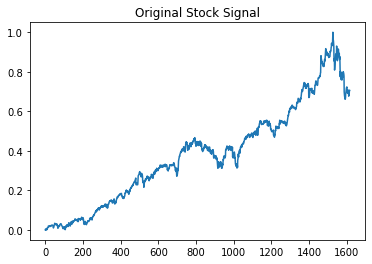

In [8]:
plt.plot(orig)
plt.title("Original Stock Signal");

In [9]:
train.shape

(804, 10)

In [10]:
x_train = train[:, :timesteps]
y_train = train[:, timesteps: timesteps + steps_ahead]
xy_train = (x_train, y_train)

In [11]:
pd.DataFrame(x_train)

,0,1,2,3,4
0,0.000554,0.003739,0.001985,0.000000,0.002308
1,0.001985,0.000000,0.002308,0.004293,0.001846
2,0.002308,0.004293,0.001846,0.004200,0.001062
3,0.001846,0.004200,0.001062,0.003970,0.007847
4,0.001062,0.003970,0.007847,0.011216,0.010524
...,...,...,...,...,...
799,0.719476,0.720176,0.723407,0.705364,0.693515
800,0.723407,0.705364,0.693515,0.701704,0.694112
801,0.693515,0.701704,0.694112,0.709296,0.694166
802,0.694112,0.709296,0.694166,0.692539,0.696552


In [12]:
pd.DataFrame(y_train)

,0,1,2,3,4
0,0.004293,0.001846,0.004200,0.001062,0.003970
1,0.004200,0.001062,0.003970,0.007847,0.011216
2,0.003970,0.007847,0.011216,0.010524,0.010339
3,0.011216,0.010524,0.010339,0.011816,0.014355
4,0.010339,0.011816,0.014355,0.019432,0.018879
...,...,...,...,...,...
799,0.701704,0.694112,0.709296,0.694166,0.692539
800,0.709296,0.694166,0.692539,0.696552,0.694491
801,0.692539,0.696552,0.694491,0.676650,0.692593
802,0.694491,0.676650,0.692593,0.684730,0.697528


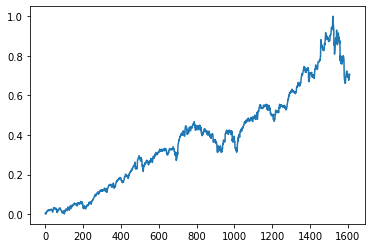

In [13]:
plt.plot(get_orig(y_train))

In [14]:
x_train.shape

(804, 5)

In [15]:
y_train.shape

(804, 5)

In [47]:
## BNN training

#could use any of the samplers modulo hyperparameters
# sampler_fns = hmc_fns
# sampler_fns = langevin_fns
sampler_fns = mala_fns



def net_fn(x):

	mlp = hk.Sequential([
		hk.Linear(128, w_init=hk.initializers.Constant(0), 
					   b_init=hk.initializers.Constant(0)), 
		jnp.tanh, 
		hk.Linear(5,   w_init=hk.initializers.Constant(0), 
					   b_init=hk.initializers.Constant(0))
		])

	return mlp(x)

In [58]:
lr = 1e-4
reg = 0.1
lik_var = 0.5

net = hk.transform(net_fn)
key = jax.random.PRNGKey(0)

sampler_init, sampler_propose, sampler_accept, sampler_update, sampler_get_params = \
    sampler_fns(key, num_samples=30, step_size=lr, init_stddev=5.0)

In [59]:
def logprob(params, xy):
    """ log posterior, assuming 
    P(params) ~ N(0,eta)
    P(y|x, params) ~ N(f(x;params), lik_var)
    """
    x, y = xy

    preds = net.apply(params, None, x)
    log_prior = - reg * sum(jnp.sum(jnp.square(p)) 
                        for p in jax.tree_leaves(params))
    log_lik = - jnp.mean(jnp.square(preds - y)) / lik_var
    return log_lik + log_prior

@jax.jit
def sampler_step(i, state, keys, batch):
    # print(state)
    # input()
    params = sampler_get_params(state)
    logp = lambda params:logprob(params, batch)
    fx, dx = jax.vmap(jax.value_and_grad(logp))(params)

    fx_prop, dx_prop = fx, dx
    # fx_prop, prop_state, dx_prop, new_keys = fx, state, dx, keys
    prop_state, keys = sampler_propose(i, dx, state, keys)

    # for RK-langevin and MALA --- recompute gradients
    prop_params = sampler_get_params(prop_state)
    fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    # for HMC
    # prop_state, dx_prop, keys = state, dx, keys
    # for j in range(5): #5 iterations of the leapfrog integrator
    # 	prop_state, keys = \
    # 		sampler_propose(i, dx_prop, prop_state, keys)

    # 	prop_params = sampler_get_params(prop_state)
    # 	fx_prop, dx_prop = jax.vmap(jax.value_and_grad(logp))(prop_params)

    accept_idxs, keys = sampler_accept(
        i, fx, fx_prop, dx, state, dx_prop, prop_state, keys
    )
    state, keys = sampler_update(
        i, accept_idxs, dx, state, dx_prop, prop_state, keys
    )


    return state, keys

In [60]:
# initialization
params = net.init(jax.random.PRNGKey(42), x_train)
sampler_state, sampler_keys = sampler_init(params)

In [61]:
params['linear']['w'].shape

(5, 128)

In [85]:
#do the sampling
niter = 50000
train_logp = np.zeros(niter)
for step in trange(niter):
    # Training log
    sampler_params = sampler_get_params(sampler_state)
    logp = lambda params:logprob(params, xy_train)
    train_logp[step] = jnp.mean(jax.vmap(logp)(sampler_params))
    
    sampler_state, sampler_keys = \
        sampler_step(step, sampler_state, sampler_keys, xy_train)


sampler_params = sampler_get_params(sampler_state)

  0%|          | 0/50000 [00:00<?, ?it/s]<ipython-input-59-34c999bbf60f>:10: FutureWarning: jax.tree_leaves is deprecated, and will be removed in a future release. Use jax.tree_util.tree_leaves instead.
  for p in jax.tree_leaves(params))
100%|██████████| 50000/50000 [31:20<00:00, 26.59it/s]


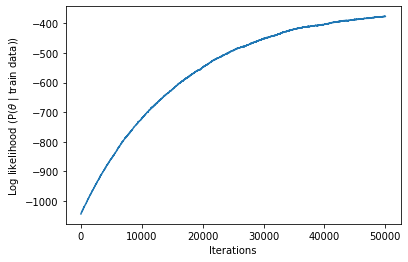

In [95]:
# Training log
ftn, axtn = plt.subplots()
axtn.plot(train_logp)
axtn.set_xlabel("Iterations")
axtn.set_ylabel("Log likelihood (P($\\theta$ | train data))")
ftn.savefig("../img/training_MALA_{}-iter.pdf".format(niter))

In [96]:
outputs = jax.vmap(net.apply, in_axes=(0, None, None))(sampler_params, None, x_train)
outputs.shape

(30, 804, 5)

In [97]:
pred_lines = np.array([ get_orig(outputs[i,:,:]) for i in range(0, outputs.shape[0])])
pred_lines.shape

(30, 1611)

In [98]:
ms = jnp.mean(pred_lines, axis=0)
ss = jnp.std(pred_lines, axis=0)

lower, uper = ms-ss, ms+ss

In [99]:
x = jax.device_put(outputs)

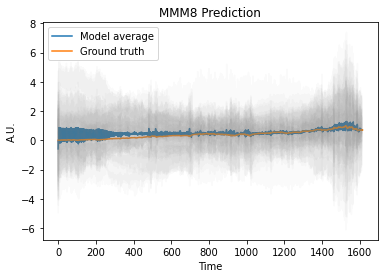

In [114]:
fmma, axmma = plt.subplots()
axmma.plot(ms, label="Model average")
axmma.plot(orig, label="Ground truth")
for i in range(outputs.shape[0]):
		axmma.plot(get_orig(outputs[i,:,:]), color="gray",alpha=0.04)
axmma.set_xlabel("Time")
axmma.set_ylabel("A.U.")
axmma.set_title("MMM8 Prediction")
axmma.legend()
fmma.savefig("../img/prediction_MALA_{}-iter.pdf".format(niter))

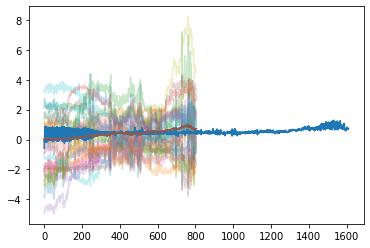

In [115]:
f, ax = plt.subplots(1)
for i in range(outputs.shape[0]):
		ax.plot(outputs[i,:,0], alpha=0.25)
ax.plot(ms, label="Mean")
ax.plot(y_train)

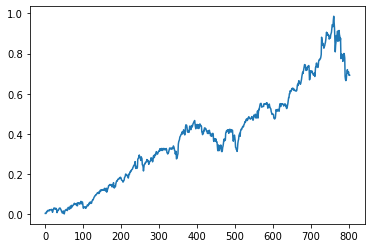

In [116]:
plt.plot(y_train[:,0])